In [1]:
import pandas as pd
import intensity_fill

%matplotlib inline

In [2]:
df = pd.read_csv("ravdess_features.csv")

excluded = [
    "modality",
    "vocal_channel",
    # "emotional_intensity",
    "statement",
    "repetition",
    "actor",
    "channels",
    "sample_width",
    "frame_rate",
    "frame_width",
    "sample_width",
    "stft_max",
    "frame_count",
    "length_ms",
    "mean",
    "max","min",
    # "kur","skew",
]
categorical = ["sex", "emotion", "emotional_itensity"]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)
df.drop(columns=excluded, inplace=True)
df = intensity_fill.fill_intensity(df)
for field in categorical:
    df[field] = pd.Categorical(df[field]).codes

modality vocal_channel    emotion emotional_intensity  \
0     audio-only        speech    fearful              normal   
1     audio-only        speech      angry              normal   
2     audio-only           NaN      happy              strong   
3     audio-only           NaN  surprised              normal   
4     audio-only          song      happy              strong   
5     audio-only        speech    fearful              normal   
6     audio-only        speech      angry              normal   
7     audio-only        speech    neutral              normal   
8     audio-only        speech       calm              normal   
9     audio-only          song        sad              strong   
10    audio-only          song        sad              strong   
11    audio-only        speech    neutral              normal   
12    audio-only        speech       calm              normal   
13    audio-only           NaN       calm              strong   
14    audio-only          song        sad              normal   
15    audio-only          song        sad              normal   
16    audio-only        speech       calm              strong   
17    audio-only        speech    fearful              strong   
18    audio-only        speech      angry              strong   
19    audio-only        speech  surprised              strong   
20    audio-only          song      happy              normal   
21    audio-only          song      happy              normal   
22    audio-only        speech    fearful              strong   
23    audio-only        speech      angry              strong   
24    audio-only        speech      angry              normal   
25    audio-only          song      happy              strong   
26    audio-only        speech  surprised              normal   
27    audio-only        speech    fearful              normal   
28    audio-only        speech  surprised              normal   
29    audio-only        speech  surprised              strong   
30    audio-only        speech    fearful              strong   
31    audio-only        speech  surprised              strong   
32    audio-only          song      happy              normal   
33    audio-only        speech      angry              strong   
34    audio-only        speech      happy              normal   
35    audio-only          song      angry              strong   
36    audio-only          song    fearful              strong   
37    audio-only          song      angry              strong   
38    audio-only          song    fearful              strong   
39    audio-only        speech      happy              normal   
40    audio-only        speech        sad              normal   
41    audio-only        speech    disgust              normal   
42    audio-only          song       calm              strong   
43    audio-only           NaN       calm              strong   
44    audio-only        speech        sad              normal   
45    audio-only        speech    disgust              normal   
46    audio-only        speech        sad              strong   
47    audio-only        speech    disgust              strong   
48    audio-only           NaN       calm              normal   
49    audio-only          song    neutral              normal   
50    audio-only          song       calm              normal   
51    audio-only          song    neutral              normal   
52    audio-only        speech        sad              strong   
53    audio-only           NaN    disgust              strong   
54    audio-only        speech      happy              strong   
55    audio-only          song      angry              normal   
56    audio-only          song    fearful              normal   
57    audio-only          song      angry              normal   
58    audio-only          song    fearful              normal   
59    audio-only        speech      happy              strong   
60    audio-only        speech    disgust  

/home/djanloo/Desktop/dynamiting/intensity_fill.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.intensity[df.intensity.isna()] = I_from_std(df["std"][df.intensity.isna()])


KeyError: 'emotional_itensity'

normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = df.values

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

Manifold knn representation

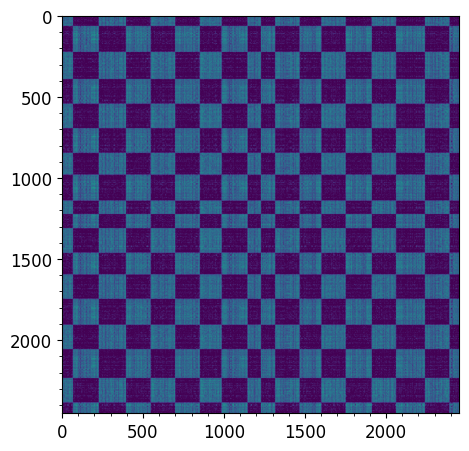

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(X_minmax,1000, mode='distance', include_self=True)
adj = A.toarray()
plt.imshow(adj)

This result is justified by the fact that the sex feature is divided in groups of males and females. This shows that the male cluster is completely disconnected from the female cluster.

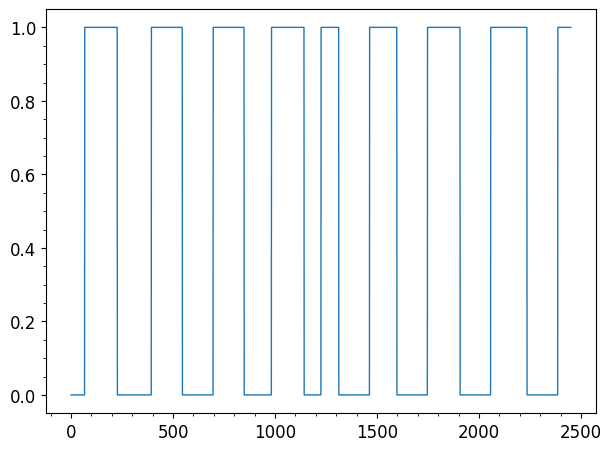

In [ ]:
plt.plot(df.sex)

So we first compute the spectral embedding over the complete dataset

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


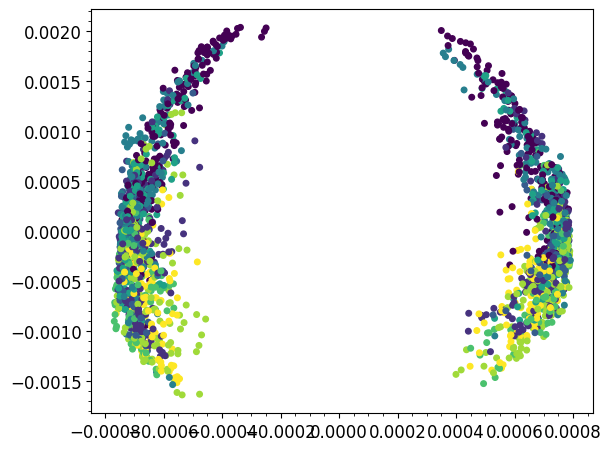

In [ ]:
from sklearn.manifold import spectral_embedding
points = spectral_embedding(adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
plt.scatter(points[:,0], points[:,1], c=df.emotion)


Then we divide in males and females

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(-0.010819356037242035,
 0.011481712169392701,
 -0.013718854048578498,
 0.015082082016502919)

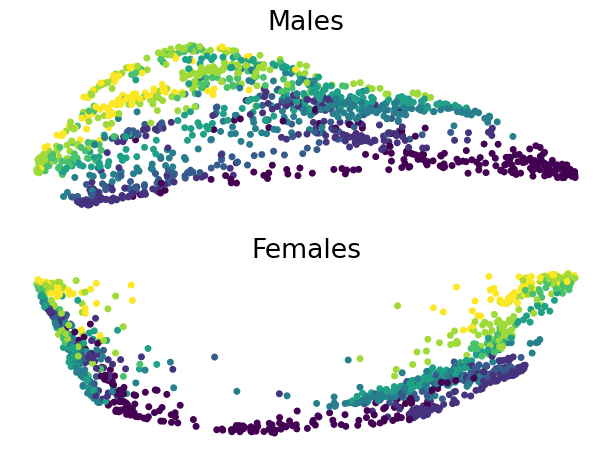

In [ ]:
Xmales = X_minmax[df.sex==1]
Xfemales = X_minmax[df.sex==0]
K = 40
males_adj = kneighbors_graph(Xmales, K, mode='distance', include_self=True).toarray()
females_adj = kneighbors_graph(Xfemales, K, mode='distance', include_self=True).toarray()
male_points = spectral_embedding(males_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
female_points = spectral_embedding(females_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
fig, axes = plt.subplots(2)
map = axes[0].scatter(male_points[:,0], male_points[:,1], c=df.emotion[df.sex==1])
axes[1].scatter(female_points[:,0], female_points[:,1], c=df.emotion[df.sex==0])
axes[0].axis("off")
axes[0].set_title("Males")
axes[1].set_title("Females")
axes[1].axis("off")

emotion  sex  intensity  zero_crossings_sum  mfcc_mean    mfcc_std  \
0           3    0 -36.793432               16995 -33.485947  134.654860   
1           0    0 -33.739051               13906 -29.502108  130.485630   
2           4    0 -32.290737               18723 -30.532463  126.577110   
3           7    0 -49.019839               11617 -36.059555  159.725160   
4           4    0 -31.214503               15137 -31.405996  122.125824   
...       ...  ...        ...                 ...        ...         ...   
2447        1    1 -45.519766                9871 -30.225578  158.845500   
2448        1    1 -43.342901                8963 -31.160332  157.499700   
2449        6    1 -36.197674                9765 -26.135280  138.133210   
2450        7    1 -45.751265                9716 -28.242815  159.943400   
2451        5    1 -40.018044                9427 -29.019236  149.188950   

       mfcc_min   mfcc_max      sc_mean       sc_std  ...    sc_kur   sc_skew  \
0    -755.22345  171.69092  5792.550744  3328.055457  ... -1.120769  0.250940   
1    -713.98560  205.00770  5197.620555  4040.931570  ... -1.531204  0.219582   
2    -726.06036  165.45653  4830.743037  3332.131300  ... -1.130153  0.436699   
3    -842.94635  190.03609  5376.446478  4053.663073  ... -1.497765  0.098802   
4    -700.70276  161.13400  5146.012474  3442.724109  ... -1.167544  0.496066   
...         ...        ...          ...          ...  ...       ...       ...   
2447 -855.92420  208.18497  5886.647366  4114.260257  ... -1.588861  0.184390   
2448 -825.37410  220.79490  6602.742127  4191.727090  ... -1.614582 -0.113920   
2449 -768.36536  235.53938  4654.156076  4231.511986  ... -1.337419  0.619346   
2450 -868.09576  219.84350  5524.736973  3596.031841  ... -1.465594  0.206481   
2451 -799.51010  219.52780  6082.676123  3963.725117  ... -1.501387  0.147574   

      stft_mean  stft_std  stft_min  stft_kur  stft_skew       std        kur  \
0      0.415250  0.335533  0.000000 -1.215025   0.403514  0.014482   9.406061   
1      0.417488  0.352380  0.000000 -1.384174   0.290905  0.020417  19.564187   
2      0.379758  0.352270  0.000000 -1.242947   0.470350  0.024317   4.881241   
3      0.407277  0.360552  0.000000 -1.445318   0.274756  0.003561  13.040259   
4      0.415974  0.350655  0.000000 -1.366742   0.318926  0.027522   7.485109   
...         ...       ...       ...       ...        ...       ...        ...   
2447   0.573838  0.304496  0.000000 -1.075888  -0.310088  0.005260   9.551363   
2448   0.591010  0.306333  0.000000 -1.026071  -0.408018  0.006836  22.517991   
2449   0.467994  0.347843  0.000000 -1.473789   0.130310  0.015384   4.964319   
2450   0.578854  0.308684  0.001565 -1.277117  -0.242668  0.005182  13.855588   
2451   0.554946  0.320787  0.000000 -1.257666  -0.237757  0.010001  12.973181   

          skew  
0     0.273153  
1     0.292157  
2     0.302659  
3    -0.081014  
4     0.414872  
...        ...  
2447  0.759247  
2448  1.073633  
2449 -0.005821  
2450 -0.110966  
2451  1.032081  

[2452 rows x 22 columns]